In [1]:
%matplotlib inline
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import glob

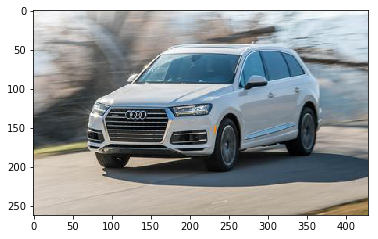

In [2]:
filenames = [filename for filename in glob.glob('./audi_q7/*.jpg')]
image = Image.open(filenames[1])
plt.imshow(np.asarray(image))

In [3]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
y_data = [[1,0]]

In [4]:
tf.set_random_seed(777)

filename_queue = tf.train.string_input_producer(filenames)
image_reader = tf.WholeFileReader()
_, image_file = image_reader.read(filename_queue)

In [5]:
class Model:
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)
            
            decode_image = tf.image.decode_jpeg(image_file, channels=3, name='decode_image')
            resized_image = tf.image.resize_images(decode_image, [256, 256])
            
            self.X_img = tf.reshape(resized_image, [-1, 256, 256, 3])
            self.Y = tf.placeholder(tf.float32, [None, 2])
            
            # Convolutional Layer #1
            conv1 = tf.layers.conv2d(inputs=self.X_img, filters=32, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            # Pooling Layer #1
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1,
                                         rate=0.7, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2,
                                         rate=0.7, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3],
                                     padding="same", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                                            padding="same", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3,
                                         rate=0.7, training=self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 32 * 32])
            dense4 = tf.layers.dense(inputs=flat,
                                     units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4,
                                         rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=2)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,
                             feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,
                             feed_dict={self.X: x_test,
                                        self.Y: y_test, self.training: training})

    def train(self, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.Y: y_data, self.training: training})

In [6]:
# sess = tf.Session()

with tf.Session() as sess:
    m1 = Model(sess=sess, name="m1")
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    total_batch = 1
    print(sess.run(tf.shape(image_file)))
    print('Learning Started!')
    # train my model
    for epoch in range(training_epochs):
        avg_cost = 0
        for i in range(total_batch):
            c, _ = m1.train(y_data=y_data)
            avg_cost += c / total_batch

        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    
    coord.request_stop()
    coord.join(threads)
    print('Learning Finished!')

0
Learning Started!
Epoch: 0001 cost = 0.000000000
Epoch: 0002 cost = 298.062622070
Epoch: 0003 cost = 0.000000000
Epoch: 0004 cost = 0.000000000
Epoch: 0005 cost = 0.000000000
Epoch: 0006 cost = 0.000000000
Epoch: 0007 cost = 0.000000000
Epoch: 0008 cost = 0.000000000
Epoch: 0009 cost = 0.000000000
Epoch: 0010 cost = 0.000000000
Epoch: 0011 cost = 0.000000000
Epoch: 0012 cost = 0.000000000
Epoch: 0013 cost = 0.000000000
Epoch: 0014 cost = 0.000000000
Epoch: 0015 cost = 0.000000000
Learning Finished!


In [ ]:
filename_queue = tf.train.string_input_producer(["file0.csv", "file1.csv"])

reader = tf.TextLineReader()
key, value = reader.read(filename_queue)

# Default values, in case of empty columns. Also specifies the type of the
# decoded result.
record_defaults = [[1], [1], [1], [1], [1]]
col1, col2, col3, col4, col5 = tf.decode_csv(
    value, record_defaults=record_defaults)
features = tf.stack([col1, col2, col3, col4])

with tf.Session() as sess:
  # Start populating the filename queue.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for i in range(1200):
    # Retrieve a single instance:
        example, label = sess.run([features, col5])

    coord.request_stop()
    coord.join(threads)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord)

#     input_image = tf.reshape(resized_image, [1, 299, 299, 3])
#     input_feed = input_image.eval()

    m1 = Model(sess=sess, name="m1")
    
    print('Learning Started!')

    # train my model
    for epoch in range(training_epochs):
        avg_cost = 0
        c, _ = m1.train(x_data=filename, y_data=y_data)
        avg_cost += c / total_batch

        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

#     coord.request_stop()
#     coord.join(threads)

    print('Learning Finished!')

    # Test model and check accuracy
    # print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))